# Setup

In [ ]:
%%capture
%pip install wandb weave

In [1]:
%%capture
%pip install fiftyone==1.10.0 sympy==1.12 torch torchvision numpy open-clip-torch

In [8]:
import os
from pathlib import Path
from google.colab import userdata

import wandb
import fiftyone as fo
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from tqdm import tqdm
import random

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Integrate Wandb

In [ ]:
# Load W&B API key from .env file and make it available as env variable
from dotenv import load_dotenv
load_dotenv()  # loads .env automatically

os.environ["WANDB_API_KEY"]

In [ ]:
# Load W&B API key from Colab Secrets and make it available as env variable
wandb_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_key

In [ ]:
wandb.login()

In [ ]:
config = {
        "embedding_size": 128,
        "optimizer_type": "AdamW",
        "fusion_strategy": "late",
        "model_architecture": "CILP_LateFusion",
        "lr": 0.01, ## why every epoch as hyperparameter?
        "batch_size": 64,
        "num_epochs": 10,
        # Number of parameters
    }

In [ ]:
metrics = {
        "epoch": 1,
        "train_loss": 0.5,
        "val_loss": 0.5,
    }

In [ ]:
wandb.init(
    project="clip-extended-assessment",
    config=config

)

In [ ]:
wandb.log(metrics)

In [ ]:
'''
def log_similarity_matrix(sim_matrix, title="Similarity Matrix"):
    # sim_matrix: (N, N) tensor or ndarray
    sim = sim_matrix.detach().cpu().numpy() if hasattr(sim_matrix, "detach") else np.array(sim_matrix)

    fig, ax = plt.subplots()
    im = ax.imshow(sim, aspect="auto")
    plt.colorbar(im, ax=ax)
    ax.set_title(title)

    wandb.log({"similarity_matrix": wandb.Image(fig)})
    plt.close(fig)
'''

In [ ]:
'''
def log_sample_predictions(images, true_labels, pred_labels, max_samples=5):
    samples = []
    for img, t, p in list(zip(images, true_labels, pred_labels))[:max_samples]:
        # assuming img is a tensor [C,H,W] in 0–1 range
        img_np = img.detach().cpu().numpy()
        caption = f"true: {t}, pred: {p}"
        samples.append(wandb.Image(img_np, caption=caption))

    wandb.log({"sample_predictions": samples})
'''

# The Dataset

In [6]:
data_path = Path("/content/drive/MyDrive/Colab Notebooks/Applied Computer Vision/Applied-Computer-Vision-Projects/Multimodal_Learning_02/multimodal_training_workshop/data")

In [9]:
IMG_SIZE = 64
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
])

class MyDataset(Dataset):
    def __init__(self, root_dir, start_idx, stop_idx):
        self.classes = ["cubes", "spheres"]
        self.root_dir = root_dir
        self.rgb = []
        self.lidar = []
        self.class_idxs = []

        for class_idx, class_name in enumerate(self.classes):
            for idx in range(start_idx, stop_idx):
                file_number = "{:04d}".format(idx)
                rbg_img = Image.open(self.root_dir + class_name + "/rgb/" + file_number + ".png")
                rbg_img = img_transforms(rbg_img).to(device)
                self.rgb.append(rbg_img)

                lidar_depth = np.load(self.root_dir + class_name + "/lidar/" + file_number + ".npy")
                lidar_depth = torch.from_numpy(lidar_depth[None, :, :]).to(torch.float32).to(device)
                self.lidar.append(lidar_depth)

                self.class_idxs.append(torch.tensor(class_idx, dtype=torch.float32)[None].to(device))

    def __len__(self):
        return len(self.class_idxs)

    def __getitem__(self, idx):
        rbg_img = self.rgb[idx]
        lidar_depth = self.lidar[idx]
        class_idx = self.class_idxs[idx]
        return rbg_img, lidar_depth, class_idx

# Configuration

In [10]:
# ----------- Constants -----------

# Dataset configuration
FIFTYONE_DATASET_NAME = "cilp_assessment"
DATASET_PATH = data_path / "assessment"


CLASSES = ["cubes", "spheres"]

# Verify Data Files

In [18]:
pairs = {}

# Paths to different modalities, organized by class
for class_name in CLASSES:
    class_dir = DATASET_PATH / class_name
    RGB_DIR = class_dir / "rgb"
    LIDAR_DIR = class_dir / "lidar"

    # Check if directories exist
    assert RGB_DIR.exists(), f"RGB directory not found: {RGB_DIR}"
    assert LIDAR_DIR.exists(), f"LIDAR directory not found: {LIDAR_DIR}"

    # Count files
    rgb_files = sorted(RGB_DIR.glob("*.png"))
    npy_files = sorted(LIDAR_DIR.glob("*.npy"))

    print(f"Found {len(rgb_files)} RGB images")
    print(f"Found {len(npy_files)} NPY LiDAR")

    # Verify matching files
    rgb_stems = {f.stem for f in rgb_files}
    npy_stems = {f.stem for f in npy_files}
    matching = rgb_stems & npy_stems

    # store all matching pairs with full paths
    pairs[class_name] = [
        {
            "stem": stem,
            "rgb": RGB_DIR / f"{stem}.png",
            "lidar": LIDAR_DIR / f"{stem}.npy",
        }
        for stem in sorted(matching)
    ]

    print(f"Matching pairs: {len(matching)}")

    if len(matching) == 0:
        print("\n⚠️  ERROR: No matching RGB/LIDAR pairs found!")
    else:
        print(f"\n✅ Ready to create dataset with {len(matching)} samples")

Found 2501 RGB images
Found 9999 NPY LiDAR
Matching pairs: 2501

✅ Ready to create dataset with 2501 samples
Found 9999 RGB images
Found 10029 NPY LiDAR
Matching pairs: 9999

✅ Ready to create dataset with 9999 samples


# Create FiftyOne Grouped Dataset
A grouped dataset allows us to associate RGB images with their corresponding point clouds.

In [19]:
# Delete existing dataset if it exists
if FIFTYONE_DATASET_NAME in fo.list_datasets():
    print(f"Deleting existing dataset: {FIFTYONE_DATASET_NAME}")
    fo.delete_dataset(FIFTYONE_DATASET_NAME)

# Create new grouped dataset
print(f"Creating new dataset: {FIFTYONE_DATASET_NAME}")
dataset = fo.Dataset(FIFTYONE_DATASET_NAME, persistent=True)
dataset.add_group_field("group", default="rgb")

print(f"✅ Created grouped dataset: {FIFTYONE_DATASET_NAME}")

Deleting existing dataset: cilp_assessment
Creating new dataset: cilp_assessment
✅ Created grouped dataset: cilp_assessment


# Add Samples to Dataset

For each matching RGB/LIDAR pair, we create a group with two slices:
- `rgb`: The camera image
- `lidar`: The point cloud

In [20]:
samples = []

for class_name, class_pairs in pairs.items():
    label_str = "cube" if class_name == "cubes" else "sphere"

    for item in class_pairs:
        # Get file paths
        rgb_path = item["rgb"]
        lidar_path = item["lidar"]

        # Create group
        group = fo.Group()

        # Create RGB sample
        rgb_sample = fo.Sample(
            filepath=str(rgb_path),
            group=group.element("rgb"),
            label=fo.Classification(label=label_str),
        )

        # Create PCD sample
        lidar_sample = fo.Sample(
            filepath=str(lidar_path),
            group=group.element("lidar"),
            label=fo.Classification(label=label_str),
        )

        samples.extend([rgb_sample, lidar_sample])

# Add all samples to dataset
dataset.add_samples(samples)

print(f"✅ Created dataset '{dataset.name}' with {len(dataset)} samples")
print("Group field:", dataset.group_field)
print("Group slices:", dataset.group_slices)

 100% |█████████████| 25000/25000 [16.1s elapsed, 0s remaining, 1.8K samples/s]       


INFO:eta.core.utils: 100% |█████████████| 25000/25000 [16.1s elapsed, 0s remaining, 1.8K samples/s]       


✅ Created dataset 'cilp_assessment' with 12500 samples
Group field: group
Group slices: ['rgb', 'lidar']


# Launch FiftyOne App

This will open the FiftyOne App in your browser where you can:
- View RGB images and point clouds side-by-side
- Use the group slices dropdown to switch between modalities
- Filter samples by metadata (positions, colors)
- Navigate through the dataset interactively

In [45]:
session = fo.launch_app(dataset, auto=False)
print(session.url)

KeyboardInterrupt: 

In [24]:
total_per_class = {cls: len(items) for cls, items in pairs.items()}
total_samples = sum(total_per_class.values())

print("Total samples per class:")
for cls, n in total_per_class.items():
    print(f"  {cls}: {n}")
print(f"\nTotal samples: {total_samples}")

Total samples per class:
  cubes: 2501
  spheres: 9999

Total samples: 12500


In [44]:
# picks the first class and first sample from pairs
any_class = CLASSES[0]
sample = pairs[any_class][0]

sample_rgb_path = sample["rgb"]
sample_lidar_path = sample["lidar"]

# RGB image
rgb_img = Image.open(sample_rgb_path)
print("RGB image:")
print("  size (width, height):", rgb_img.size)
print("  mode:", rgb_img.mode)
print("  format:", rgb_img.format)

# LiDAR depth map
lidar = np.load(sample_lidar_path)
print("\nLiDAR depth map:")
print("  shape:", lidar.shape)
print("  dtype:", lidar.dtype)

RGB image:
  size (width, height): (64, 64)
  mode: RGBA
  format: PNG

LiDAR depth map:
  shape: (64, 64)
  dtype: float32


In [26]:
train_ratio = 0.8

splits = {
    "train": {},
    "val": {},
}

for cls, items in pairs.items():
    n = len(items)
    n_train = int(n * train_ratio)

    splits["train"][cls] = items[:n_train]
    splits["val"][cls] = items[n_train:]

train_size = sum(len(v) for v in splits["train"].values())
val_size = sum(len(v) for v in splits["val"].values())

print("Train/validation sizes:")
for cls in CLASSES:
    print(
        f"  {cls}: train={len(splits['train'][cls])}, "
        f"val={len(splits['val'][cls])}"
    )
print(f"\nTotal train: {train_size}")
print(f"Total val:   {val_size}")


Train/validation sizes:
  cubes: train=2000, val=501
  spheres: train=7999, val=2000

Total train: 9999
Total val:   2501


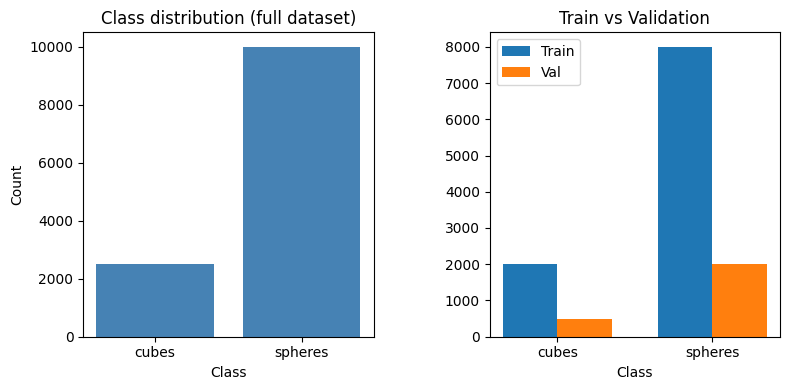

In [35]:
# --- Data ---
class_names = list(total_per_class.keys())
counts_full = [total_per_class[c] for c in class_names]

train_counts = [len(splits["train"][c]) for c in class_names]
val_counts   = [len(splits["val"][c])   for c in class_names]

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# left: full dataset distribution
axes[0].bar(class_names, counts_full, color="steelblue")
axes[0].set_title("Class distribution (full dataset)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# right: train vs validation split
x = range(len(class_names))
width = 0.35

axes[1].bar([i - width/2 for i in x], train_counts, width=width, label="Train")
axes[1].bar([i + width/2 for i in x], val_counts,   width=width, label="Val")
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names)
axes[1].set_title("Train vs Validation")
axes[1].set_xlabel("Class")
axes[1].legend()

# show plots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

plt.show()


# Cleanup
To delete the dataset and free up space:

In [ ]:
# Uncomment to delete the dataset
# fo.delete_dataset(DATASET_NAME)
# print(f"Deleted dataset: {DATASET_NAME}")